In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
import astropy
from   astropy.io import fits as pyfits
import random

import csv
import sys
import os
import importlib as imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar
import argparse
import json

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

In [2]:
# select mission, target, and paths

MISSION = "Kepler"
TARGET  = "K00277"
PRIMARY_DIR = '/Users/research/projects/alderaan/'
TRACE_FILE  = '/Users/research/projects/alderaan/Traces/K00277/K00277_sin_ttvs.fits'

# Make sure the necessary paths exist

In [3]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs    
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Get sinusoidal TTV model posteriors

In [4]:
# Read in the fits file with saved traces

with pyfits.open(TRACE_FILE) as sin_trace:
    header  = sin_trace[0].header
    hdulist = pyfits.HDUList(sin_trace)
    
    NDRAWS, NPL = sin_trace['RP'].shape
    
    # stellar parameters
    RSTAR  = sin_trace['RSTAR'].data
    MSTAR  = sin_trace['MSTAR'].data
    U      = sin_trace['U'].data
    U1, U2 = U[:,0], U[:,1]
    
    # planetary parameters
    T0   = sin_trace['T0'].data
    P    = sin_trace['P'].data
    LOGR = sin_trace['LOGR'].data
    RP   = sin_trace['RP'].data
    B    = sin_trace['B'].data
    
    # TTV parameters
    C0 = sin_trace['C0'].data
    C1 = sin_trace['C1'].data
    C2 = np.zeros_like(C0)
    C3 = np.zeros_like(C0)
    C4 = np.zeros_like(C0)
    C5 = np.zeros_like(C0)
    
    A1 = np.zeros_like(C0)
    B1 = np.zeros_like(C0)
    A2 = np.zeros_like(C0)
    B2 = np.zeros_like(C0)
    AMP = np.zeros_like(C0)
    
    FPLUS  = np.zeros_like(C0)
    FMINUS = np.zeros_like(C0)
    FTTV1  = np.zeros_like(C0)
    FTTV2  = np.zeros_like(C0)
    
    TTS = [None]*NPL
    
    for npl in range(NPL):
        try: C2[:,npl] = sin_trace['C2_{0}'.format(npl)].data
        except: pass
        
        try: C3[:,npl] = sin_trace['C3_{0}'.format(npl)].data
        except: pass
        
        try: C4[:,npl] = sin_trace['C4_{0}'.format(npl)].data
        except: pass
        
        try: C5[:,npl] = sin_trace['C5_{0}'.format(npl)].data
        except: pass

        try: A1[:,npl] = sin_trace['A1_{0}'.format(npl)].data
        except: pass
        
        try: B1[:,npl] = sin_trace['B1_{0}'.format(npl)].data
        except: pass
        
        try: A2[:,npl] = sin_trace['A2_{0}'.format(npl)].data
        except: pass
        
        try: B2[:,npl] = sin_trace['B2_{0}'.format(npl)].data
        except: pass
        
        try: AMP[:,npl] = sin_trace['amp_{0}'.format(npl)].data
        except: pass
        
        try: FPLUS[:,npl] = sin_trace['FPLUS_{0}'.format(npl)].data
        except: pass
        
        try: FMINUS[:,npl] = sin_trace['FMINUS_{0}'.format(npl)].data
        except: pass
        
        try: FTTV1[:,npl] = sin_trace['FTTV1_{0}'.format(npl)].data
        except: pass
        
        try: FTTV2[:,npl] = sin_trace['FTTV2_{0}'.format(npl)].data
        except: pass       
        
        try: TTS[npl] = sin_trace['TTS_{0}'.format(npl)].data
        except: pass

In [5]:
with pyfits.open(TRACE_FILE) as sin_trace:
    header  = sin_trace[0].header
    hdulist = pyfits.HDUList(sin_trace)
    
    NDRAWS, NPL = sin_trace['RP'].shape
    
    # GP parameters
    LOGSW4 = np.zeros((NDRAWS,4))
    LOGW0  = np.zeros((NDRAWS,4))
    LOGQ   = np.zeros((NDRAWS,4))
    
    for z in range(4):
        try: LOGSW4[:,z] = sin_trace['LOGSW4_{0}'.format(z)].data
        except: pass
        
        try: LOGW0[:,z] = sin_trace['LOGW0_{0}'.format(z)].data
        except: pass
        
        try: LOGQ[:,z] = sin_trace['LOGQ_{0}'.format(z)].data
        except: pass

# Get transit times, linear ephemeris and O-C

In [6]:
epochs = np.zeros(NPL)
periods = np.zeros(NPL)

sin_transit_times = []
sin_ephemeris = []
transit_inds = []

for npl in range(NPL):   
    sin_transit_times.append(np.median(TTS[npl], axis=0))
    
    t0  = np.median(T0[:,npl])
    per = np.median(P[:,npl])
    tts = sin_transit_times[npl]
    
    tinds = np.array(np.floor((tts - t0 + per/2) / per), dtype='int')
    
    epochs[npl] = t0
    periods[npl] = per
    sin_ephemeris.append(t0 + per*tinds)
    transit_inds.append(tinds)

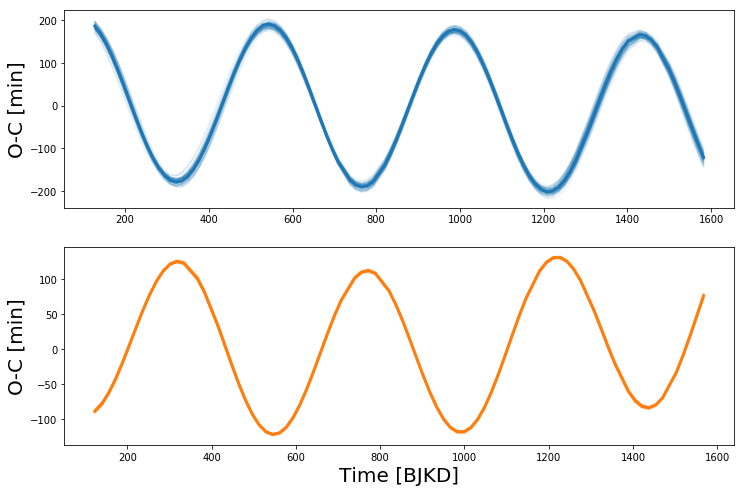

In [7]:
draws = random.sample(range(NDRAWS), 50)

fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    for d in draws:
        xtime = TTS[npl][d]
        yomc  = (xtime - (T0[d,npl] + P[d,npl]*transit_inds[npl]))*24*60

        axes[npl].plot(xtime, yomc, alpha=0.1, color='C{0}'.format(npl))    
    
    xtime = sin_transit_times[npl]
    yomc  = (sin_transit_times[npl]-sin_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, color='C{0}'.format(npl), lw=3)
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
    
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)    
plt.show()

# Read in detrended lightcurves and independent TTV estimates

In [8]:
# Load detrended lightcurves
try:
    lc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    lc = None
    
try:
    sc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    sc = None

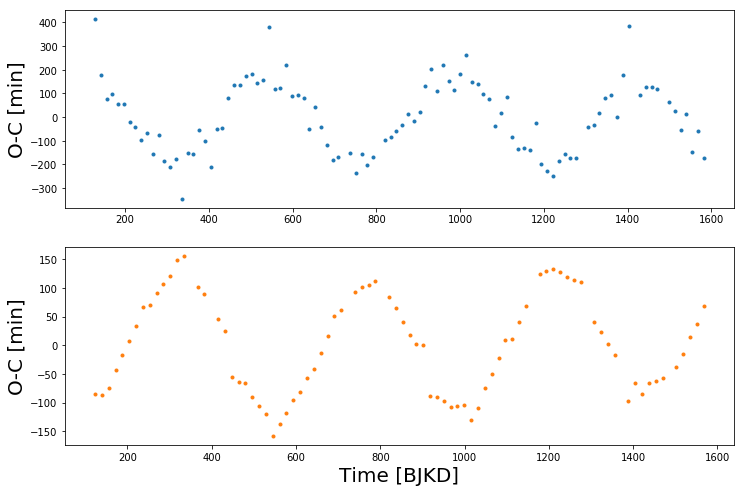

In [9]:
# Read in QuickTTV estimates and calculate linear ephemeris for each planet
transit_inds = []
indep_transit_times = []
indep_ephemeris = []


for npl in range(NPL):
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_map_indep_ttvs.txt'
    data_in  = np.genfromtxt(fname_in)
    
    transit_inds.append(data_in[:,0])
    indep_transit_times.append(data_in[:,1])
    
    pfit = np.polyfit(transit_inds[npl], indep_transit_times[npl], 1)
    
    indep_ephemeris.append(np.polyval(pfit, transit_inds[npl]))
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

In [10]:
# get estimate of ttv uncertainty and a reasonable buffer
ttv_err_mu = np.zeros(NPL)
ttv_err_sd = np.zeros(NPL)
ttv_buffer = np.zeros(NPL)

for npl in range(NPL):
    # estimate TTV amplitude
    ttv_err_mu[npl] = np.std(indep_transit_times[npl] - sin_transit_times[npl])
    ttv_err_sd[npl] = np.std(indep_transit_times[npl] - indep_ephemeris[npl])

    # based on scatter in independent times, set threshold so not even one outlier is expected
    N   = len(transit_inds[npl])
    eta = np.max([3., stats.norm.interval((N-1)/N)[1]])

    ttv_buffer[npl] = eta*ttv_err_mu[npl]

# Fit the independent TTVs using a Matern 3/2 kernel

In [13]:
omc_maps = []
omc_traces = []

for npl in range(NPL):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])
    
    
    with pm.Model() as omc_model:
        # nuissance parameters
        mean = pm.Normal("mean", mu=0, sd=15)
        logvar = pm.Normal("logvar", mu=0, sd=15)
        

        # set up kernel and GP
        log_sig = pm.Normal("log_sig", mu=0, sd=10)
        log_rho = pm.Normal("log_rho", mu=0, sd=10)
        
        kernel = exo.gp.terms.Matern32Term(log_sigma=log_sig, log_rho=log_rho)
        gp = exo.gp.GP(kernel, xtime, T.exp(logvar)*T.ones(len(xtime)))
        
        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential("obs", gp.log_likelihood(yomc - mean))
        
        gp_pred = pm.Deterministic("gp_pred", gp.predict())

        
    with omc_model:
        omc_maps.append(exo.optimize(start=omc_model.test_point))
        omc_traces.append(pm.sample(tune=5000, draws=3000, start=omc_maps[npl], chains=2,
                                    step=exo.get_dense_nuts_step(target_accept=0.9)))

optimizing logp for variables: [log_rho, log_sig, logvar, mean]
40it [00:00, 154.64it/s, logp=7.172775e+01]
message: Optimization terminated successfully.
logp: -141.78560512481715 -> 71.72774889306145
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_rho, log_sig, logvar, mean]
Sampling 2 chains: 100%|██████████| 16000/16000 [00:18<00:00, 856.95draws/s] 
optimizing logp for variables: [log_rho, log_sig, logvar, mean]
42it [00:00, 171.00it/s, logp=1.032307e+02] 
message: Optimization terminated successfully.
logp: -117.53807994252792 -> 103.23068401552867
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_rho, log_sig, logvar, mean]
Sampling 2 chains: 100%|██████████| 16000/16000 [00:16<00:00, 952.43draws/s] 


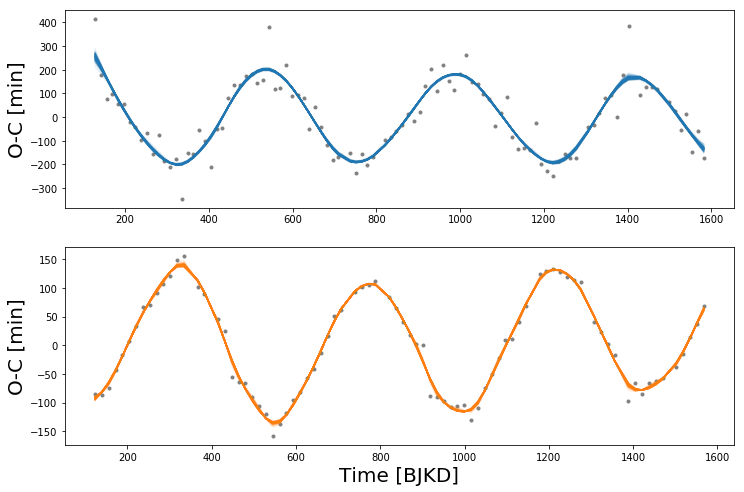

In [18]:
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl in range(NPL):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='grey')

    draws = np.random.randint(0, 3000, size=100)
    for d in draws:
        trend = (omc_traces[npl]["gp_pred"][d] + omc_traces[npl]["mean"][d])*24*60
        axes[npl].plot(xtime, trend, c='C{0}'.format(npl), alpha=0.1)    
    
    trend = (np.median(omc_traces[npl]["gp_pred"],0) + np.median(omc_traces[npl]["mean"],0))*24*60
    #axes[npl].plot(xtime, trend, c='C{0}'.format(npl), lw=3)
    
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

In [16]:
omc_traces[npl]["mean"].shape

(6000,)

# Set fixed values for star and planet parameters

In [ ]:
# identify which sample is closest to the median for all parameters

dist_sq = ((U1 - np.median(U1))/np.std(U1))**2
dist_sq = ((U2 - np.median(U2))/np.std(U2))**2
dist_sq = ((RSTAR - np.median(RSTAR))/np.std(RSTAR))**2
dist_sq = ((MSTAR - np.median(MSTAR))/np.std(MSTAR))**2

for npl in range(NPL):
    dist_sq += ((RP[:,npl] - np.median(RP[:,npl]))/np.std(RP[:,npl]))**2
    dist_sq += ((B[:,npl] - np.median(B[:,npl]))/np.std(B[:,npl]))**2
    dist_sq += ((P[:,npl] - np.median(P[:,npl]))/np.std(P[:,npl]))**2
    dist_sq += ((T0[:,npl] - np.median(T0[:,npl]))/np.std(T0[:,npl]))**2


loc = np.argmin(dist_sq)

In [ ]:
# grab star and planet parameters for that sample
u = U1[loc], U2[loc]

Rstar = RSTAR[loc]
Mstar = MSTAR[loc]

rp = RP[loc]
b  = B[loc]

periods = P[loc]
epochs = T0[loc]

sma = get_sma(periods, Mstar)
durs = get_dur_tot(periods, rp, Rstar, b, sma)

# Set up GP

In [ ]:
# Read in noise model GP priors
gp_percs = []

for z in range(4):
    fname_in = NOISE_DIR + TARGET + '_shoterm_gp_priors_{0}.txt'.format(z)
    
    with open(fname_in) as infile:
        gp_percs.append(json.load(infile))


# Read in quarter-by-quarter variances
var_by_quarter = np.genfromtxt(NOISE_DIR + TARGET + '_var_by_quarter.txt')[:,1]

In [ ]:
# this grabs a single sample based on the transit parameters
gp_priors = []

for z in range(4):
    gpi = {}

    gpi['logw0'] = (LOGW0[:,z][loc], 0.0)
    gpi['logSw4'] = (LOGSW4[:,z][loc], 0.0)
    gpi['logQ'] = (LOGQ[:,z][loc], 0.0)
        
    gp_priors.append(gpi)

# Grab the relevant data

In [ ]:
# grab data near transits for each quarter
all_time = []
all_flux = []
all_mask = []
all_dtype = []


if sc is not None:
    for q in range(18):
        if np.isin(q, sc.quarter)*np.isin(q, lc.quarter):
            raise ValueError("Double counting data in both short and long cadence")


        elif np.isin(q, sc.quarter):
            use = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time.append(sc.time[use])
                all_flux.append(sc.flux[use])
                all_mask.append(sc.mask[:,use])
                all_dtype.append('short')
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_mask.append(None)
                all_dtype.append('none')


        elif np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
            
            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_mask.append(lc.mask[:,use])
                all_dtype.append('long')
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_mask.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_mask.append(None)
            all_dtype.append('none')
            
else:
    for q in range(18):
        if np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)

            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_mask.append(lc.mask[:,use])
                all_dtype.append('long')
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_maskappend(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_mask.append(None)
            all_dtype.append('none')



# check which quarters have data
good = (np.array(all_dtype) == 'short') + (np.array(all_dtype) == 'long')
quarters = np.arange(18)[good]
nq = len(quarters)

lc_quarters = np.arange(18)[np.array(all_dtype) == 'long']
sc_quarters = np.arange(18)[np.array(all_dtype) == 'short']

In [ ]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')

# Identify overlapping transits

In [ ]:
dur_max = np.max(durs)
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(sin_transit_times[i]), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for tt in sin_transit_times[j]:
                overlap[i] += np.abs(sin_transit_times[i] - tt) < dur_max

In [ ]:
thresh = np.zeros(19)
thresh[0] = np.min(np.hstack([lc.time, sc.time]))

for q in range(18):
    thresh[q+1] = np.max(np.hstack([lc.time[lc.quarter==q],sc.time[sc.quarter==q]]))
    
transit_quarter = [None]*NPL

for npl in range(NPL):
    stt = sin_transit_times[npl]
    transit_quarter[npl] = np.zeros(len(stt), dtype='int')

    for q in range(18): 
        transit_quarter[npl][(stt >= thresh[q])*(stt<thresh[q+1])] = q

# Count up transits and break into subgroups if $N_{trans} > 64$ 

In [ ]:
# fit at most MAX_GROUP_SIZE transits at a time
MAX_GROUP_SIZE = 64

ngroups = []
tts_group = []

for npl in range(NPL):
    num_trans_total = len(overlap[npl])
    num_trans_nonoverlap = (np.sum(~overlap[npl]))
    
    ngroups.append(int(np.ceil(num_trans_nonoverlap/MAX_GROUP_SIZE)))
    
    groupsize = int(np.ceil(num_trans_nonoverlap/ngroups[npl]))
    r = np.repeat(np.arange(1,ngroups[npl]+1), groupsize)
    
    tg = np.zeros(num_trans_total, dtype="int")
    tg[~overlap[npl]] = np.random.choice(r, size=num_trans_nonoverlap, replace=False)
    
    tts_group.append(tg)

In [ ]:
group_mask = []

for j, q in enumerate(quarters):
    t_ = all_time[j]
    m_ = np.array(all_mask[j].copy(), dtype="int")
    
    for npl in range(NPL):
        for i, t0 in enumerate(sin_transit_times[npl]):
            m_[npl][np.abs(t_-t0)/durs[npl] < 3.0] = tts_group[npl][i]

    group_mask.append(m_)

        
for npl in range(NPL):
    plt.figure(figsize=(20,3))
    
    for j, q in enumerate(quarters):
        t_ = all_time[j]
        f_ = all_flux[j]
        m_ = group_mask[j][npl]
        
        for ng in range(1,ngroups[npl]+1):
            plt.plot(t_[m_==ng], f_[m_==ng], ".", c="C{0}".format(ng-1))
        
    plt.show()

# Fit HBM transit times

In [ ]:
tts_chains = []
offset_chains = []
pop_sd_chains = []


for npl in range(NPL):
    for g in range(1,ngroups[npl]+1):
        print("\nPLANET {0}, GROUP {1}".format(npl,g))
        
        # identify which quarters and which_seasons have data
        use = tts_group[npl] == g
        
        wq = np.unique(transit_quarter[npl][use])
        ws = np.unique(wq % 4)
                
        # grab transit times
        fixed_tts = np.copy(sin_transit_times[npl][use])
        fixed_inds = np.copy(transit_inds[npl][use])
        
        print(np.sum(use), "transits")
        print("quarters:", wq)

        # now build the model
        with pm.Model() as hbm_model:
            
            # hierarchical (hyper)parameters
            log_pop_var = pm.Normal('log_pop_var', mu=2*np.log(ttv_err_mu[npl]), sd=2*np.log(3*ttv_err_sd[npl]/ttv_err_mu[npl]))
            pop_sd = pm.Deterministic('pop_sd', T.sqrt(T.exp(log_pop_var)))
            
            log_nu_off = pm.Normal('nu_off', mu=0, sd=5)
            nu = pm.Deterministic('nu', 1.0 + T.exp(log_nu_off))

            # transit times
            tt_offset = pm.StudentT('tt_offset', nu=nu, shape=len(fixed_tts))
            transit_times = pm.Deterministic('tts', fixed_tts + tt_offset*pop_sd)
            
            # set up stellar model and planetary orbit
            exoSLC = exo.StarryLightCurve(u)
            orbit  = exo.orbits.TTVOrbit(transit_times=[transit_times], transit_inds=[fixed_inds], 
                                         b=b[npl], r_star=Rstar, m_star=Mstar)

            # track period and epoch
            T0 = pm.Deterministic('T0', orbit.t0)
            P  = pm.Deterministic('P', orbit.period)
            
            # nuissance parameters (one mean flux; variance by quarter)
            flux0 = pm.Normal('flux0', mu=np.ones(len(wq)), sd=np.sqrt(var_by_quarter[wq])/4, shape=len(wq))
            logvar = pm.Normal('logvar', mu=np.log(var_by_quarter[wq]), sd=np.log(4)*np.ones(len(wq)), shape=len(wq))

            
            # build the GP kernel using a different noise model for each season
            logSw4 = [None]*4
            logw0  = [None]*4
            logQ   = [None]*4
            kernel = [None]*4

            for i in range(4):
                if np.isin(i, ws):
                    gpi = gp_priors[i]              

                    logSw4[i] = gpi['logSw4'][0]
                    logw0[i] = gpi['logw0'][0]
                    logQ[i] = gpi['logQ'][0]

                    kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
                
                else:
                    kernel[i] = None
            
            
            # now evaluate the model for each quarter
            light_curves       = [None]*len(wq)
            summed_light_curve = [None]*len(wq)
            model_flux         = [None]*len(wq)
            
            gp = [None]*len(wq)
            

            for j, q in enumerate(wq):
                # here's the data
                t_ = all_time[q]
                f_ = all_flux[q]
                m_ = group_mask[q][npl] == g
                
                if np.sum(m_) == 0:
                    raise ValueError("Got unexpected empty data array")

                   # set oversampling factor
                if all_dtype[q] == 'short':
                    oversample = 1
                elif all_dtype[q] == 'long':
                    oversample = 15

                # calculate light curves
                light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp[npl], t=t_[m_], oversample=oversample)
                summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(t_[m_]))
                model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
                
                # here's the GP (w/ kernel by season)
                gp[j] = exo.gp.GP(kernel[q%4], t_[m_], T.exp(logvar[j])*T.ones(len(t_[m_])))
                
                
                # add custom potential (log-prob fxn) with the GP likelihood
                pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(f_[m_] - model_flux[j]))
                
                
        # sample from the posterior
        with hbm_model:
            hbm_trace = pm.sample(tune=1, draws=1, start=hbm_model.test_point, chains=2,
                                  step=exo.get_dense_nuts_step(target_accept=0.9))

        tts_chains.append(np.copy(np.array(hbm_trace['tts'])))
        offset_chains.append(np.copy(np.array(hbm_trace['tt_offset'])))
        pop_sd_chains.append(np.copy(np.array(hbm_trace['pop_sd'])))

In [ ]:
# make primary HDU
primary_hdu = pyfits.PrimaryHDU()
header = primary_hdu.header
header['TARGET'] = TARGET
primary_hdu.header = header
    
# add it to HDU list
hbm_hdulist = []
hbm_hdulist.append(primary_hdu)




# grab all samples from trace
i = 0

for npl in range(NPL):
    combo_tts = []
    combo_offset = []
    combo_pop_sd = []
    combo_groupno = []

    for j in range(ngroups[npl]):
        combo_tts.append(tts_chains[i])
        combo_offset.append(offset_chains[i])
        combo_pop_sd.append(pop_sd_chains[i])
        combo_groupno.append((j+1)*np.ones(tts_chains[i].shape[1], dtype="int"))
        
        i += 1
        
    combo_tts = np.hstack(combo_tts)
    combo_offset = np.hstack(combo_offset)
    combo_pop_sd = np.vstack(combo_pop_sd).swapaxes(0,1)
    combo_groupno = np.hstack(combo_groupno)

    order = np.argsort(np.median(combo_tts,0))

    combo_tts = combo_tts[:,order]
    combo_offset = combo_offset[:,order]
    combo_groupno = combo_groupno[order]
    
    
    # add to HDUList
    hbm_hdulist.append(pyfits.ImageHDU(combo_tts, name='TTS_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_offset, name='OFFSET_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_pop_sd, name='POP_SD_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_groupno, name='GROUP_{0}'.format(npl)))

    
hbm_hdulist = pyfits.HDUList(hbm_hdulist)
hbm_hdulist.writeto(TRACE_DIR + TARGET + '_hbm_ttvs.fits', overwrite=True)

print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))

# >> HERE'S WHERE UNUSED CODE STARTS <<

### (A) Individual planets, independent seasons

In [ ]:
tts_chains = []
offset_chains = []
pop_sd_chains = []

for npl in range(NPL):
    for z in range(4):
        tqz = transit_quarter[npl]
        tqz = np.unique(tqz[tqz%4 == z])

        
        # grab transit times
        fixed_tts = sin_transit_times[npl]
        
        use_lc = (~overlap[npl])*(transit_quarter[npl] % 4 == z)*np.isin(transit_quarter[npl], lc_quarters)
        use_sc = (~overlap[npl])*(transit_quarter[npl] % 4 == z)*np.isin(transit_quarter[npl], sc_quarters)
        use = use_lc + use_sc
   

        # now build the model
        with pm.Model() as hbm_model:
            flux0 = 1.0

            log_pop_var = pm.Normal('log_pop_var', mu=2*np.log(ttv_amps[npl]), sd=np.log(4.5))
            pop_sd = pm.Deterministic('pop_sd', T.exp(0.5*log_pop_var))
            
            # transit times
            tt_offset = pm.StudentT('tt_offset', nu=2, shape=len(fixed_tts[use]))
            #tt_offset = pm.Normal('tt_offset', mu=0, sd=1, shape=len(fixed_tts[use]))
            transit_times = pm.Deterministic('tts', fixed_tts[use] + tt_offset*pop_sd)


            # set up stellar model and planetary orbit
            exoSLC = exo.StarryLightCurve(u)
            orbit  = exo.orbits.TTVOrbit(transit_times=[transit_times], transit_inds=[transit_inds[npl][use]], 
                                         b=b[npl], r_star=Rstar, m_star=Mstar)
            
            
            # track period and epoch
            T0 = pm.Deterministic('T0', orbit.t0)
            P  = pm.Deterministic('P', orbit.period)


            # build the GP kernel
            logSw4 = gp_priors[z]['logSw4'][0]
            logw0  = gp_priors[z]['logw0'][0]
            logQ   = gp_priors[z]['logQ'][0]
            
            kernel = exo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, log_Q=logQ)  
            
            # nuissance parameters (one mean flux; variance by quarter)
            flux0 = pm.Normal('flux0', mu=np.ones(len(tqz)), sd=np.sqrt(var_by_quarter[tqz])/4, shape=len(tqz))
            logvar = pm.Normal('logvar', mu=np.log(var_by_quarter[tqz]), sd=np.log(4)*np.ones(len(tqz)), shape=len(tqz))
            
            # now evaluate the model for each quarter
            light_curves       = [None]*len(tqz)
            summed_light_curve = [None]*len(tqz)
            model_flux         = [None]*len(tqz)

            gp      = [None]*len(tqz)
            gp_pred = [None]*len(tqz)

            for j, q in enumerate(tqz):
                # set oversampling factor
                if all_dtype[q] == 'short':
                    oversample = 1
                    
                    muse = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)
                    m = (sc.mask[npl,muse] == 1)*(np.array(sc.mask[:,muse], dtype='int').sum(0) == 1)

                elif all_dtype[q] == 'long':
                    oversample = 15
                    
                    muse = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
                    m = (lc.mask[npl,muse] == 1)*(np.array(lc.mask[:,muse], dtype='int').sum(0) == 1)
                    
                # calculate light curves
                light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp[npl], t=all_time[q][m], oversample=oversample)
                summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(all_time[q][m]))
                model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])

                # here's the GP (w/ kernel by season)
                gp[j] = exo.gp.GP(kernel, all_time[q][m], T.exp(logvar[j])*T.ones(len(all_time[q][m])))


                # add custom potential (log-prob fxn) with the GP likelihood
                pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(all_flux[q][m] - model_flux[j]))
            

        with hbm_model:
            hbm_trace = pm.sample(tune=5, draws=1, start=hbm_model.test_point, chains=2,
                                  step=exo.get_dense_nuts_step(target_accept=0.9))
        
        tts_chains.append(np.copy(np.array(hbm_trace['tts'])))
        offset_chains.append(np.copy(np.array(hbm_trace['tt_offset'])))
        pop_sd_chains.append(np.copy(np.array(hbm_trace['pop_sd'])))

In [ ]:
# make primary HDU
primary_hdu = pyfits.PrimaryHDU()
header = primary_hdu.header
header['TARGET'] = TARGET
primary_hdu.header = header
    
# add it to HDU list
hbm_hdulist = []
hbm_hdulist.append(primary_hdu)
    
# grab all samples from trace
for npl in range(NPL):
    combo_tts = []
    combo_offset = []
    combo_pop_sd = []
    
    for z in range(4):
        combo_tts.append(tts_chains[4*npl+z])
        combo_offset.append(offset_chains[4*npl+z])
        combo_pop_sd.append(pop_sd_chains[4*npl+z])
        
    combo_tts = np.hstack(combo_tts)
    combo_offset = np.hstack(combo_offset)
    combo_pop_sd = np.vstack(combo_pop_sd).swapaxes(0,1)

    order = np.argsort(np.median(combo_tts,0))

    combo_tts = combo_tts[:,order]
    combo_offset = combo_offset[:,order]

    # add to HDUList
    hbm_hdulist.append(pyfits.ImageHDU(combo_tts, name='TTS_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_offset, name='OFFSET_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_pop_sd, name='POP_SD_{0}'.format(npl)))

    
hbm_hdulist = pyfits.HDUList(hbm_hdulist)
hbm_hdulist.writeto(TRACE_DIR + TARGET + '_hbm_ttvs.fits', overwrite=True)

print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))

In [ ]:
plt.figure()

for i in range(4):

    xtime = np.median(tts_chains[i],0)
    yomc = np.median(offset_chains[i],0)*np.median(pop_sd_chains[i])*24*60
    yerr = np.std(offset_chains[i],0)*np.median(pop_sd_chains[i])*24*60

    plt.errorbar(xtime, yomc, yerr=yerr, fmt='bo')

plt.show()

    
plt.figure()

for i in range(4,8):

    xtime = np.median(tts_chains[i],0)
    yomc = np.median(offset_chains[i],0)*np.median(pop_sd_chains[i])*24*60
    yerr = np.std(offset_chains[i],0)*np.median(pop_sd_chains[i])*24*60

    plt.errorbar(xtime, yomc, yerr=yerr, fmt='ro')

plt.show()


### (B) Individual planets, simultaneous seasons

In [ ]:
tts_chains = []
offset_chains = []
pop_sd_chains = []

for npl in range(NPL):
    tqz = np.unique(transit_quarter[npl])
        
    # grab transit times
    fixed_tts = sin_transit_times[npl]
        
    use_lc = (~overlap[npl])*np.isin(transit_quarter[npl], lc_quarters)
    use_sc = (~overlap[npl])*np.isin(transit_quarter[npl], sc_quarters)
    use = use_lc + use_sc
   

    # now build the model
    with pm.Model() as hbm_model:
        # hierarchical parameters
        log_pop_var = pm.Normal('log_pop_var', mu=2*np.log(ttv_amps[npl]), sd=np.log(4.5))
        pop_sd = pm.Deterministic('pop_sd', T.exp(0.5*log_pop_var))

        # transit times
        tt_offset = pm.StudentT('tt_offset', nu=2, shape=len(fixed_tts[use]))
        #tt_offset = pm.Normal('tt_offset', mu=0, sd=1, shape=len(fixed_tts[use]))
        transit_times = pm.Deterministic('tts', fixed_tts[use] + tt_offset*pop_sd)


        # set up stellar model and planetary orbit
        exoSLC = exo.StarryLightCurve(u)
        orbit  = exo.orbits.TTVOrbit(transit_times=[transit_times], transit_inds=[transit_inds[npl][use]], 
                                     b=b[npl], r_star=Rstar, m_star=Mstar)
            
            
        # track period and epoch
        T0 = pm.Deterministic('T0', orbit.t0)
        P  = pm.Deterministic('P', orbit.period)


        # build the GP kernel using a different noise model for each season
        logSw4 = [None]*4
        logw0  = [None]*4
        logQ   = [None]*4
        kernel = [None]*4

        for i in range(4):
            gpi = gp_priors[i]              
            
            logSw4[i] = gpi['logSw4'][0]
            logw0[i] = gpi['logw0'][0]
            logQ[i] = gpi['logQ'][0]
                

            kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])

        # nuissance parameters (one mean flux; variance by quarter)
        flux0 = pm.Normal('flux0', mu=np.ones(len(tqz)), sd=np.sqrt(var_by_quarter[tqz])/4, shape=len(tqz))
        logvar = pm.Normal('logvar', mu=np.log(var_by_quarter[tqz]), sd=np.log(4)*np.ones(len(tqz)), shape=len(tqz))

        # now evaluate the model for each quarter
        light_curves       = [None]*len(tqz)
        summed_light_curve = [None]*len(tqz)
        model_flux         = [None]*len(tqz)

        gp      = [None]*len(tqz)
        gp_pred = [None]*len(tqz)

        
        for j, q in enumerate(tqz):
            # set oversampling factor
            if all_dtype[q] == 'short':
                oversample = 1

                muse = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)
                m = (sc.mask[npl,muse] == 1)*(np.array(sc.mask[:,muse], dtype='int').sum(0) == 1)

            elif all_dtype[q] == 'long':
                oversample = 15

                muse = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
                m = (lc.mask[npl,muse] == 1)*(np.array(lc.mask[:,muse], dtype='int').sum(0) == 1)

            # calculate light curves
            light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp[npl], t=all_time[q][m], oversample=oversample)
            summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(all_time[q][m]))
            model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])

            # here's the GP (w/ kernel by season)
            gp[j] = exo.gp.GP(kernel[q%4], all_time[q][m], T.exp(logvar[j])*T.ones(len(all_time[q][m])))


            # add custom potential (log-prob fxn) with the GP likelihood
            pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(all_flux[q][m] - model_flux[j]))
            

    with hbm_model:
        hbm_trace = pm.sample(tune=50, draws=10, start=hbm_model.test_point, chains=2,
                              step=exo.get_dense_nuts_step(target_accept=0.9))

    tts_chains.append(np.copy(np.array(hbm_trace['tts'])))
    offset_chains.append(np.copy(np.array(hbm_trace['tt_offset'])))
    pop_sd_chains.append(np.copy(np.array(hbm_trace['pop_sd'])))

In [ ]:
# make primary HDU
primary_hdu = pyfits.PrimaryHDU()
header = primary_hdu.header
header['TARGET'] = TARGET
primary_hdu.header = header
    
# add it to HDU list
hbm_hdulist = []
hbm_hdulist.append(primary_hdu)
    
# grab all samples from trace
for npl in range(NPL):
    combo_tts = []
    combo_offset = []
    combo_pop_sd = []
    
    combo_tts.append(tts_chains[npl])
    combo_offset.append(offset_chains[npl])
    combo_pop_sd.append(pop_sd_chains[npl])
        
    combo_tts = np.hstack(combo_tts)
    combo_offset = np.hstack(combo_offset)
    combo_pop_sd = np.vstack(combo_pop_sd).swapaxes(0,1)

    order = np.argsort(np.median(combo_tts,0))

    combo_tts = combo_tts[:,order]
    combo_offset = combo_offset[:,order]

    # add to HDUList
    hbm_hdulist.append(pyfits.ImageHDU(combo_tts, name='TTS_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_offset, name='OFFSET_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_pop_sd, name='POP_SD_{0}'.format(npl)))

    
hbm_hdulist = pyfits.HDUList(hbm_hdulist)
hbm_hdulist.writeto(TRACE_DIR + TARGET + '_hbm_ttvs.fits', overwrite=True)

print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))

In [ ]:
for npl in range(NPL):

    xtime = np.median(tts_chains[npl],0)
    yomc = np.median(offset_chains[npl],0)*np.median(pop_sd_chains[npl])*24*60
    yerr = np.std(offset_chains[npl],0)*np.median(pop_sd_chains[npl])*24*60

    plt.figure()
    plt.errorbar(xtime, yomc, yerr=yerr, fmt='o', color='C{0}'.format(npl))
    plt.show()

### (C) Fit transits one-by-one

In [ ]:
u = np.median(U1), np.median(U2)

Rstar = np.median(RSTAR)
Mstar = np.median(MSTAR)

rp = np.median(RP,0)
b  = np.median(B,0)

In [ ]:
NDRAWS = 500

for npl in range(2,3):
    print(npl)
    
    tinds = transit_inds[npl]
    tts = sin_transit_times[npl]
    
    t0  = epochs[npl]
    per = periods[npl]
    
    
    timeslist = []
    
    for i, j in enumerate(tinds):        
        use = (sc.mask[npl] == 1) * (np.abs(sc.time - tts[i]) < per/2)
        
        t_ = sc.time[use]
        f_ = sc.flux[use]
        e_ = sc.error[use]
        
        
        if np.sum(use) > 0:            
            with pm.Model() as model:
                tc = pm.Normal('tc', mu=tts[i], sd=ttv_amps[npl])
                flux0 = pm.Normal('flux0', mu=1.0, sd=0.01)
                
                # set up stellar model and planetary orbit
                exoSLC = exo.StarryLightCurve(u)
                orbit  = exo.orbits.KeplerianOrbit(t0=tc, period=per, b=b[npl], r_star=Rstar, m_star=Mstar)


                light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp[npl], t=t_, oversample=1)
                summed_light_curve = pm.math.sum(light_curves, axis=-1) + flux0*T.ones(len(t_))
                model_flux = pm.Deterministic('model_flux', summed_light_curve)
                
                obs = pm.Normal("obs", mu=model_flux, sd=e_, observed=f_)
            
            
            with model:
                trace = pm.sample(tune=2000, draws=NDRAWS, start=model.test_point, chains=2, \
                                  step=exo.get_dense_nuts_step(target_accept=0.9))              
            
            timeslist.append(trace['tc'])
            
            #fig, axes = plt.subplots(1,2, figsize=(12,4))
            
            #axes[0].plot(t_, f_, '.', c='grey')
            #axes[0].plot(t_, map_soln['model_flux'], c='k')
            
            #draws = random.sample(range(NDRAWS), 50)
            #for d in draws:            
            #    axes[0].plot(t_, trace['model_flux'][d], c='C{0}'.format(npl), lw=2, alpha=0.3)
           
            #axes[1].hist(trace['tc'], color='C{0}'.format(npl))
            
            #plt.show()


In [ ]:
tts = np.array(timeslist)

tts_med = np.median(tts,1)
tts_std = np.std(tts,1)

inds = np.floor(((tts_med - tts_med % per) + 0.5*per) / per)

pfit = np.polyfit(inds, tts_med, 1)
ephem = np.polyval(pfit, inds)

xtime = 1.0*tts_med
yomc  = (tts_med - ephem)*24*60
yerr  = tts_std*24*60



plt.figure(figsize=(13,5))
plt.errorbar(xtime, yomc, yerr=yerr, fmt='o', c='C{0}'.format(npl))
plt.plot(transit_inds, sin_transit_times-s, c='k')
plt.show()